In [4]:
import sys
sys.path.append('/home/emastr/phd/')

from boundary_solvers.gauss_grid_2d import *
import numpy as np
import matplotlib.pyplot as plt
from util.plot_tools import *
from boundary_solvers.blobs import *
from scipy.sparse.linalg import gmres, LinearOperator
from util.unet import *
import torch
import torch.autograd as agrad
from operators.stokes_operator import StokesOperator

### Unrolled iterative reconstruction
In this short project we examine the possibility to accelerate the mapping from boundary data to boundary conditions using deep learning. Given boundary data $u \colon \partial\Omega \to \mathbb{R}$ of a region $\Omega$ of Euclidean space $\mathbb{R}^d$ whose boundary is parameterised by some $\gamma \colon [0,2\pi] \to \mathbb{R}^d$, the density $\rho$ is obtained as

\begin{equation}
 \mathcal{A}_\gamma \rho = u
\end{equation}

where the operator $\mathcal{A}_\gamma$ is parameterised by $\gamma$. Without getting to caught up in the details, GMRES takes the iterative form

\begin{equation}
     \rho_{n} = step(\mathcal{A}_\gamma, \rho_{m<n}),\qquad \rho_0 = u.
\end{equation}

Due to well-posedness of $\mathcal{A}_\gamma$, the number of iterations required is low for smooth systems. In such cases, the number of iterations required for machine precision is on the scale of 10-20. However, when introducing corners into the geometry, it becomes harder to obtain good convergence. Furthermore, preconditioners can be expensive so if the corner geometry is unpredictable (i.e. the angle of the corner), this solution needs improvement. 


#### Learning $\mathcal{A}_\gamma^{-1}$

A natural starting point for finding $\mathcal{A}_\gamma^{-1}$ is to look at an iterative scheme. The following residual update describes many iterative schemes for solving near-singular systems of equations

\begin{equation}
    \rho_{n} = \rho_{n-1} + \Lambda({A}_\gamma \rho_{n-1}, \rho_{n-1}),\qquad \rho_0 = u.
\end{equation}

Here, $\Lambda\colon U \times P \to P$ maps $A_\gamma \rho_{n-1}$ and $\rho_{n-1}$ to a residual update. The idea is to truncate these iterations to, say $n\geq N$ and replace $\Lambda$ with a neural network $\Lambda_{\theta^n}$ with parameters $\theta_n$:

\begin{equation}
    \rho_{n} = \rho_{n-1} + \Lambda_{\theta_n}({A}_\gamma \rho_{n-1}, \rho_{n-1}),\qquad \rho_0 = u, \qquad n = 1,2,\dots,N
\end{equation}

#### Simple case
For example, here's a simple case where the network is an unrolled scheme with all parameters fixed except for the initial guess, which depends on one unknown parameter.

0.3442376939785492
0.03286535238241907
0.009747928683900365
0.0024726602451235276
0.0005962379795596498
0.00029554273848285547
7.831910025213281e-05
3.771405869455535e-05
1.949117346576815e-05
7.015451591806968e-06
4.392251540776112e-06
2.6027130730047374e-06
1.1489859129741062e-06
7.694458457657931e-07
5.679676609929558e-07
2.973398513268891e-07
1.8451903661807212e-07
1.568103997266324e-07
1.1106976993316292e-07
6.524228265277714e-08


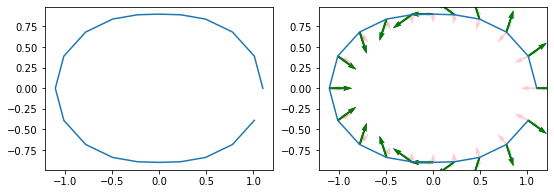

In [5]:
# Example of simple boundary
N = 20
dt = np.pi * 2 / N
t  = torch.arange(0,N) * dt
w = torch.ones(N,) * dt

k = 3
c = 0.1

# Circle
z = torch.exp(1j * t) + c * torch.exp(k*1j * t)
dz = 1j * torch.exp(1j * t) + c* k*1j * torch.exp(k*1j * t);
ddz = 1j * 1j *torch.exp(1j * t) + c * k *k * 1j*1j * torch.exp(k*1j * t);

# Square
#ones = torch.ones(t.shape, dtype=torch.complex64)
#z = torch.where(t<=np.pi, torch.where(t<=np.pi/2, ones  + 1j * 2*t/np.pi, ones * 1j + ones + 2*(np.pi/2 - t)/np.pi),\
#                          torch.where(t<=3*np.pi/2, 1j * (ones + 2*(np.pi - t)/np.pi), 0*1j + 2*(t-3*np.pi/2)/np.pi))
#dz = torch.where(t<=np.pi, torch.where(t<=np.pi/2, 2j * ones/np.pi,  -2*ones/np.pi),\
#                          torch.where(t<=3*np.pi/2, -2j * ones/np.pi, 0*1j + 2*ones/np.pi))
#ddz = torch.zeros_like(t)

# Stokes operator
A = StokesOperator(z, dz, ddz, w)


# Target density
v0 = torch.exp(2j * t)[None, None, :]
#v0_stack = torch.concat([torch.real(v0), torch.imag(v0)],axis=2)
v0_stack = torch.concat([torch.real(v0), torch.imag(v0)],axis=1)


def conjgrad(A, v0, nsteps):
    vr = v0
    r = v0 - A(vr)
    p = r
    dot = lambda x, y: torch.tensordot(x,y,[[1,2],[1,2]])
    for k in range(nsteps):
        Ap = A(p)
        Atp = A.eval_transpose(p)
        rdotr = dot(r,r)
        a = rdotr/dot(p,Atp)
        vr = vr + a*p
        r = r - a*Ap
        b = dot(r,r)/rdotr
        p = r + b*p
        #vr = vr - 0.001*A.mse_grad(vr, v0_stack)#(A(vr)-v0_stack)
        print(torch.norm(A(vr)-v0).item())
    return vr

vr = conjgrad(A,v0_stack, 20)
vr = A(vr)
    
v = A(v0_stack)
x, y = torch.real(z), torch.imag(z)
dx, dy = torch.real(1j*dz), torch.imag(1j*dz)
vx0, vy0 = v[0,0,:], v[0,1,:]
ux0, uy0 = torch.real(v0.squeeze()), torch.imag(v0.squeeze())
rx0, ry0 = vr[0,0,:], vr[0,1,:]

plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
plt.plot(x, y)

plt.subplot(1,2,2)
plt.plot(x, y)
#plt.scatter(x,y)
plt.quiver(x,y,dx,dy,color='red',alpha=0.2)
plt.quiver(x,y,ux0,uy0, scale=10)#, alpha=0.2)
plt.quiver(x,y,vx0,vy0, color='green', alpha=0.2)
plt.quiver(x,y,rx0,ry0, color='green',scale=10)#, alpha=0.2)


0.020032167434692383
0.0010600090026855469


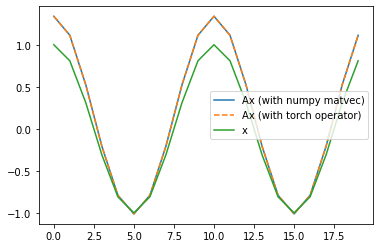

In [6]:
## Compare to numpy
tnp, wnp = t.numpy(), w.numpy()
n_pts = N

# Parametrisation, derivatives
znp = z.numpy()
dznp = dz.numpy()
ddznp = ddz.numpy()
dznp_conj = np.conjugate(dznp)


v0np = v0.numpy().squeeze()


# Assert boundary integral is zero (or sufficiently close to it)
b = 1j*v0np
sysVec = np.vstack([np.real(b)[:,None], np.imag(b)[:,None]])
# SYSTEM:
# Ax + Bxc = b -> (Ar + jAi)(xr+jxi) + (Br + jBi)(xr - jxi) = br + jbi
# (Arxr - Aixi + Brxr + Bixi) + j(Arxi + Aixr + Bixr - Brxi) = br + jbi
def matvec(v):
    if len(v.shape) == 1:
        v = v[:, None]

    w = v.copy()  # eye * v
    v_real = v[0:n_pts]
    v_imag = v[n_pts:]

    idx = np.arange(0, n_pts)
    for n in range(n_pts):
        m = (idx != n)  # Non-singular indices
        assert sum(m) == n_pts - 1

         # K
        integrand = np.zeros(wnp.shape, dtype=np.complex128)
        integrand[m] = np.imag(dznp[m] / (znp[m] - znp[n])) * wnp[m] / np.pi
        integrand[n] = np.imag(ddznp[n] / (2 * dznp[n])) * wnp[n] / np.pi

         # K conj
        integrand_conj = np.zeros(wnp.shape, dtype=np.complex128)
        integrand_conj[m] = -np.imag(dznp[m] * np.conjugate(znp[m] - znp[n])) / \
                              np.conjugate(znp[m] - znp[n]) ** 2 * wnp[m] / np.pi
        integrand_conj[n] = -np.imag(ddznp[n] * dznp_conj[n]) / (2 * dznp_conj[n] ** 2) * wnp[n] / np.pi

        k11 =  np.real(integrand) + np.real(integrand_conj)#+(np.arange(0,n_pts)==n)
        k21 =  np.imag(integrand) + np.imag(integrand_conj)
        k12 = -np.imag(integrand) + np.imag(integrand_conj)
        k22 =  np.real(integrand) - np.real(integrand_conj)#+(np.arange(0,n_pts)==n)

        # Integrate                
        #print(k11.shape)
        w[n] += k11 @ v_real + k12 @ v_imag
        w[n_pts + n] += k21 @ v_real + k22 @ v_imag
    return w

import time

T = time.time()
for i in range(10):
    y = matvec(np.vstack([np.real(v0np)[:,None], np.imag(v0np)[:,None]]))
T = time.time() - T
print(T)


T = time.time()
with torch.no_grad():
    for i in range(10):
        #y2 = StokesOperator.matvec(v0, z, dz, ddz, w)
        y2 = A(v0_stack)[0,0,:]
    T = time.time() - T
print(T)

plt.plot(y.flatten()[:N], label="Ax (with numpy matvec)")
plt.plot(y2.flatten()[:N], '--', label="Ax (with torch operator)")
plt.plot(v0_stack[0,0,:]*1.0, label="x")
plt.legend()
    

In [7]:
# Network
a = torch.Tensor([1.5])
a.requires_grad_(True)


# Network
def net(a):
    v = torch.exp(1j * a * t)[None, None, :]
    v = torch.concat([torch.real(v), torch.imag(v)], axis=1)
    v.requires_grad_(True)
    for i in range(5):
        mse = torch.norm(A(v) - v0_stack)**2
        v = v - 0.1 * agrad.grad(mse, v, retain_graph=True, create_graph=True)[0]
    return v

# Training
grads = []
alist = torch.linspace(0.5,3,20)
for ai in alist:
    ai.requires_grad_(True)
    loss = torch.norm(net(ai) - v0_stack) ** 2
    
    ai.retain_grad()
    loss.backward()
    
    grads.append(ai.grad.item())
    
a_train = []
agrad_train = []
for i in range(30):
    loss = torch.norm(net(a) - v0_stack) ** 2 * dt
    a.retain_grad()
    loss.backward()    
    
    a_train.append(a.detach())
    agrad_train.append(a.grad.item())
    
    a = a - 0.01*a.grad
    a.grad = None
    

v = net(a).detach()
 
x, y = torch.real(z), torch.imag(z)
ux, uy = v[0,0,:], v[0,1,:]
ux0, uy0 = torch.real(v0.squeeze()), torch.imag(v0.squeeze())


/home/emastr/anaconda3/envs/pimlenv/lib/python3.8/site-packages/numpy/ma/core.py:2829: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  _data = np.array(data, dtype=dtype, copy=copy,
/home/emastr/anaconda3/envs/pimlenv/lib/python3.8/site-packages/numpy/ma/core.py:2829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,


(-1.2100000000000002, 1.2100000000000002, -0.99, 0.99)

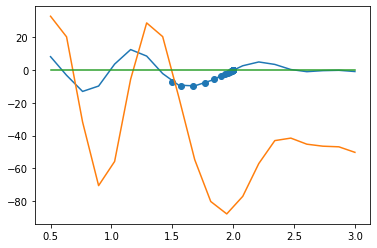

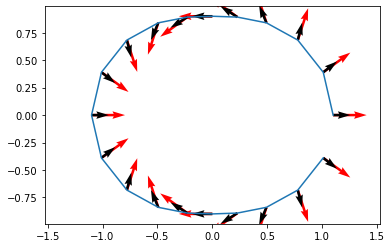

In [8]:
plt.plot(alist, np.array(grads) * dt)
plt.scatter(a_train, agrad_train)
plt.plot(alist, 4 * np.cumsum(np.array(grads))*dt)
plt.plot(alist, 0*alist)


plt.figure()

plt.plot(x, y)
plt.quiver(x, y, ux0, uy0, color = 'red', scale=10)
plt.quiver(x, y, ux, uy)
plt.axis("equal")

## Unrolled architecture
We proceed to construct a more complicated architecture

torch.Size([1, 2, 20])
[torch.Size([1, 20]), torch.Size([1, 20]), torch.Size([1, 20]), torch.Size([1, 20]), torch.Size([1, 2, 20])]


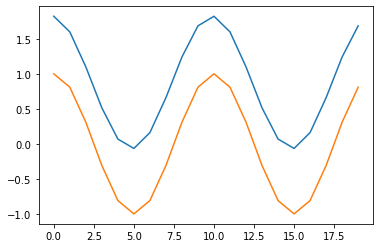

In [9]:
from util.unet import *

settings = {"in_channels":2, 
            "min_out_channels":4,
            "out_channels":2,
            "depth":3, 
            "batch_norm":2, 
            "width":2,
            "kernel_size":3,
            "padding":1,
            "padding_mode":'circular',
            "activation":nn.Sigmoid}

#activations = {"sigmoid": nn.Sigmoid, "relu": nn.ReLU}
#settings["activation"] = activations[settings["activation"]]




class Unrolled(nn.Module):
    
    def __init__(self, n_iter, net_factory, net_args=None, device="cpu"):
        super(Unrolled, self).__init__()
        
        self.device = device
        self.n_iter = n_iter
        if net_args is None:
            self.nets = nn.ModuleList([net_factory() for i in range(n_iter)])
        else:
            self.nets = nn.ModuleList([net_factory(net_args[i]) for i in range(n_iter)])
        self.nets.to(device)
        
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        param x: tuple (x, y) with x = (N,4,K) and y = (N, C, K) 
        where x = [z, dz, ddz, w, p0] (boundary data + initial data)
        and y = input data to feed the network together with the gradient of the residual.
        """
        if len(x) == 5:
            z, dz, ddz, w, v0 = x 
            op = StokesOperator(z, dz, ddz, w)
        elif len(x) == 2:
            op, v0 = x
            
        out = v0.clone()
        for i in range(self.n_iter):
            out = out + self.nets[i](op(out)-v0)
            #out = out + self.nets[i](op.mse_grad(out, v0))
            #for n in range(N):
            #    #out[n:n+1,:,:] += self.nets[i](op.mse_grad(out[n:n+1,:,:], v0))            
            #    #out[n:n+1,:,:] += self.nets[i](op(out[n:n+1,:,:])-v0[n:n+1,:,:])
            #tmp = StokesOperator.matvec(out, z, dz, ddz, w)-v0
            #out[n:n+1,:,:] += self.nets[i](tmp)
                
        return out
    
    
def factory():
    #return Unet(**settings)
    return nn.Sequential(nn.Conv1d(2,2,3,padding=1,padding_mode='circular'),\
                         nn.ReLU(),\
                        nn.Conv1d(2,2,3,padding=1,padding_mode='circular'))

    
net = Unrolled(5, factory, None)

v0_stack = torch.cat([torch.real(v0), torch.imag(v0)], dim=1)
print(v0_stack.shape)
inp = (z[None,:], dz[None,:], ddz[None,:], w[None,:], v0_stack)

print([x.shape for x in inp])
out = net(inp).detach()
plt.plot(out[0,0,:])
plt.plot(v0_stack.detach()[0,0,:])

#torch.norm(net(inp)).backward()
#print([p.grad for p in net.parameters()])

Let's Load some data and try it out! We approximate derivatives using central difference schemes.

X is (N,C,M) with N datapoints, C=4 channels,        and M discretisation pts. C=(real(z), imag(z), real(u0),imag(u0)).


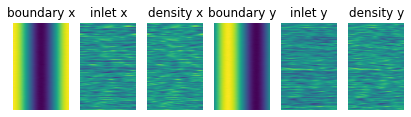

In [18]:
device = "cuda:1"
#data = torch.load("/home/emastr/phd/data/discretised_data_gradflow_big.torch")
data = torch.load("/home/emastr/phd/data/discretised_data_gradflow_big_circles.torch")


print(data['info'])
net.to(device)
net.device=device
X = data["X"].to(device)[0:200,:,:]
Y = data["Y"].to(device)[0:200,:,:]

titles=["boundary x", "boundary y", "inlet x", "inlet y"]
plt.figure(figsize=(7,3))
for i in range(2):
    for j in range(2):
        plt.subplot(1,6,i+3*j+1)
        plt.imshow(X[:,2*i+j,:].squeeze().cpu().numpy())
        plt.title(titles[2*i+j])
        remove_axes(plt.gca())
        
ytitles = ["density x", "density y"]
for i in range(2):
    plt.subplot(1,6,3+3*i)
    plt.imshow(Y[:,i,:].squeeze().cpu().numpy())
    plt.title(ytitles[i])
    remove_axes(plt.gca())

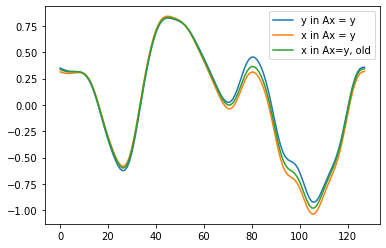

In [23]:
i = 130
X1 = X[i:i+1, :, :]
Y1 = Y[i:i+1, :, :]
(Z1, V01) = X1[:, 0, :] + 1j * X1[:, 1, :], X1[:, 2:4, :]
W1 = np.pi * 2/X1.shape[2]*torch.ones(Z1.shape, device=device)
dZ1 = (torch.roll(Z1,1,dims=1) - torch.roll(Z1,-1,dims=1))/(2*W1)
ddZ1 = (torch.roll(Z1,1,dims=1) - 2*Z1 + torch.roll(Z1,-1,dims=1))/W1**2

optrain = StokesOperator(Z1, dZ1, ddZ1, W1)
Y2 = optrain(V01)


plt.plot(V01[0,1,:].detach().cpu(), label="y in Ax = y")
plt.plot(Y2[0,1,:].detach().cpu(), label="x in Ax = y")
plt.plot(Y1[0,1,:].detach().cpu(), label="x in Ax=y, old")
plt.legend()

In [64]:
# Define Z
N = X.shape[2]
(Z, V0) = X[:, 0, :] + 1j * X[:, 1, :], X[:,2:4,:]
#Z.requires_grad_(False)
#V0.requires_grad_(False)

W = np.pi * 2 / N * torch.ones(Z.shape, device=device)
dZ = (torch.roll(Z,1,dims=1) - torch.roll(Z,-1,dims=1))/(2*W)
ddZ = (torch.roll(Z,1,dims=1) - 2*Z + torch.roll(Z,-1,dims=1))/W**2



#inp = (Z, dZ, ddZ, W, V0)
M = 100
Ztrain, dZtrain, ddZtrain, Wtrain, V0train = Z[:M,:], dZ[:M,:], ddZ[:M,:], W[:M,:], V0[:M,:,:]
Ytrain = Y[:M,:,:]
optrain = StokesOperator(Ztrain, dZtrain, ddZtrain, Wtrain)

Ztest, dZtest, ddZtest, Wtest, V0test = Z[M:,:], dZ[M:,:], ddZ[M:,:], W[M:,:], V0[M:,:,:]
Ytest = Y[M:,:,:]
optest = StokesOperator(Ztest,dZtest,ddZtest, Wtest)

inptrain = (optrain, V0train)
inptest = (optest, V0test)
#print([x.shape for x in inp])
#plt.plot(np.real(Z[0,:]), np.imag(Z[0,:]))
#plt.quiver(np.real(Z[0,:]), np.imag(Z[0,:]), np.real(1j*dZ[0,:]), np.imag(1j*dZ[0,:]), alpha=0.1)
#plt.quiver(np.real(Z[0,:]), np.imag(Z[0,:]), np.real(ddZ[0,:]), np.imag(ddZ[0,:]), alpha=0.1)
#plt.quiver(np.real(Z[0,:]), np.imag(Z[0,:]), V0[0,0,:], V0[0,1,:], color='red')
#plt.quiver(np.real(Z[0,:]), np.imag(Z[0,:]), Y[0,0,:], Y[0,1,:], color='blue')

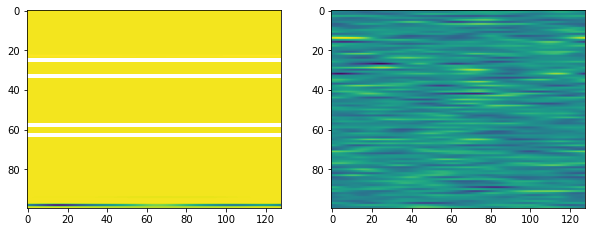

In [44]:
def dot(x,y):
    (M,C,N) = x.shape
    d = torch.zeros(M,1,1, dtype=x.dtype, device=x.device)
    for m in range(M):
        d[m,:,:] = torch.tensordot(x[m,:,:], y[m,:,:], [[0,1], [0,1]])
    return d

def conjgrad(A, v0, nsteps, TOL):
    vr = v0
    r = v0 - A(vr)
    p = r
    for k in range(nsteps):
        Ap = A(p)
        #Atp = A.eval_transpose(p)
        rdotr = dot(r,r)
        pdotAp = dot(p,Ap)
        
        a = rdotr/pdotAp
        
        vr = vr + a*p
        r = r - a*Ap
        b = dot(r,r)/rdotr
        p = r + b*p
        #vr = vr - 0.001*A.mse_grad(vr, v0_stack)#(A(vr)-v0_stack)
        #print(torch.norm(A(vr)-v0).item())
    return vr

rectest = conjgrad(optest, V0test, 10, TOL=1e-8)
out = optest(V0test)
out = optest(V0test  - out)
out=rectest
plt.figure(figsize=(10,10))

plt.subplot(121)
plt.imshow(out[:,0,:].squeeze().cpu())

plt.subplot(122)
plt.imshow(Ytest[:,0,:].squeeze().cpu())


In [ ]:
losses = []
testloss = []
loss_fcn = nn.MSELoss()
benchloss = loss_fcn(V0test, Ytest).item()
optim = torch.optim.Adam(net.parameters())#, lr=0.01)
for i in range(4000):
    
    #optim = torch.optim.Adam(net.parameters())
    
    out = net(inptrain)
    loss = loss_fcn(out, Ytrain)
    loss.backward()
    optim.step()
        
    losses.append(loss.item())
    testloss.append(loss_fcn(net(inptest), Ytest).item())
        
    optim.zero_grad()
        
    print(f"Step {i}, train loss = {losses[-1]}, test loss = {testloss[-1]}, benchmark={benchloss}", end="\r")
    
    if i % 30 == 0:
        torch.save({"state dict": net.state_dict(), 
                    "loss": losses}, 
                    f"/home/emastr/phd/data/unet_state_dict_2022_05_20.Torch") # Kernel size 5, stride 2

In [ ]:
plt.semilogy(losses)
plt.semilogy(testloss)
plt.semilogy([benchloss,]*len(losses))

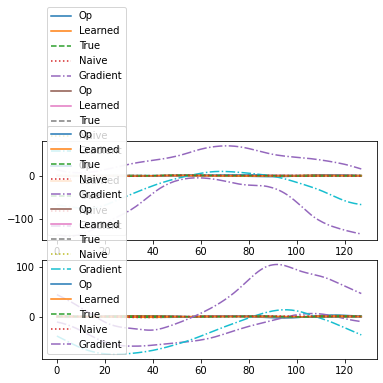

In [84]:
#### 
## IMORGON
## BUGGFIXA! 
# VAD GÖR ATT OP-inte funkar? 
# Högre dimension? 
####




n = 5
Vtest = net(inptest)

V01jtest = torch.zeros_like(V0test)
V01jtest[:,0,:] = -V0test[:,1,:]
V01jtest[:,1,:] = V0test[:,0,:]


# five iterations of gradient stepping
Vgrad = V0test
for i in range(300):
    step = optest.mse_grad(Vgrad, V0test)
    step = optest(Vgrad) - V0test
    Vgrad = Vgrad - step/torch.norm(step) * 30
    Vgrad = Vgrad - 0.1*(optest(Vgrad)-V0test)
    print([torch.norm(optest(Vgrad)-V0test).item(), torch.norm(optest(Ytest)-V0test).item()],end="\r")
opy = optest(Ytest)
    


    
for n in [0,1,2]:
    for i in range(2):
        plt.subplot(2,1,i+1)
        plt.plot(opy[n,i,:].cpu().detach().numpy(), label="Op")
        plt.plot(Vtest[n,i,:].cpu().detach().numpy(), label="Learned")
        plt.plot(Ytest[n,i,:].cpu().detach().numpy(), '--', label="True")
        plt.plot(V0test[n,i,:].cpu().detach().numpy(), ':', label="Naive")
        plt.plot(Vgrad[n,i,:].cpu().detach().numpy(), '-.', label="Gradient")

        plt.legend()


1.7668785540377692


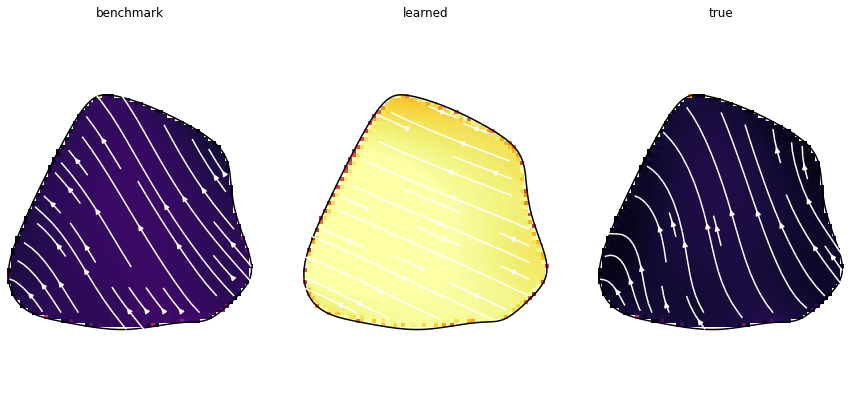

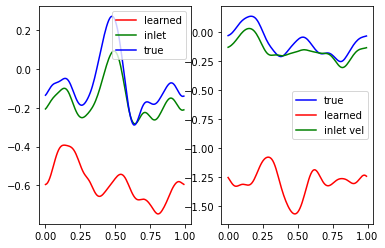

In [14]:
K_in = 20
K_out = 40
M = 128
data = ProblemData.random_problemdata(K=K_in, 
                                      bound_amplitude=0.2,
                                      bound_decay=0.6,#0.5, 
                                      cond_amplitude=0.2,#.5
                                      cond_decay=0.6,#.4
                                      allow_intersections=False, 
                                      allow_net_flow=False,
                                      decay_type="exp",
                                      refine=4,
                                      tol=1e-13)

problem = data.to_problem(n=0)
problem.geometry.grid.ABSCISSA = np.linspace(-1,1,M+1)[:-1]
problem.geometry.grid.WEIGHTS = np.ones((M,)) * 2/M


t, w = problem.geometry.grid.get_grid_and_weights()
z = problem.geometry.eval_param(t=t) 
dz = problem.geometry.eval_param(t=t, derivative=1)
ddz = problem.geometry.eval_param(t=t, derivative=2)

v0 = problem.condition(t)[None, :]
v0_inp = np.vstack([np.real(v0), np.imag(v0)])[None,:]
v0 = 1j*v0.flatten()

#print(v0.shape)
inp = (z, dz, ddz, w, v0_inp)
inp = tuple(torch.from_numpy(x).to(device) for x in inp)

d = net(inp)
learned = (d[0,0,:] + 1j*d[0,1,:]).detach().cpu().numpy()
benchmark = v0
problem.solve()

densities = [benchmark, learned, problem.density]
titles = ["benchmark", "learned", "true"]

field = lambda z: np.abs(problem.evaluate(z))

plt.figure(figsize=(15,7))
for i in range(3):
    problem.density = densities[i]
    plt.subplot(1,3,i+1)
    plt.title(titles[i])
    problem.geometry.plot(ax = plt.gca(), color="black")
    problem.geometry.plot_field(ax=plt.gca(), func=field, npts=60, apply_mask=True, cmap="inferno", vmin=0, vmax=3)
    problem.geometry.plot_stream(ax=plt.gca(), func=problem.evaluate, npts=60, apply_mask=True, color="white", density=0.5)
    plt.axis("equal")
    remove_axes(plt.gca())

plt.figure()

angle = t/2/np.pi
plt.subplot(121)
plt.plot(angle, np.real(learned),'r-', label="learned")
plt.plot(angle, np.real(v0), 'g-', label="inlet")
plt.plot(angle, np.real(problem.density), 'b-', label="true")
plt.legend()

plt.subplot(122)
plt.plot(angle, np.imag(problem.density), 'b-', label="true")
plt.plot(angle, np.imag(learned), 'r-', label="learned")
plt.plot(angle, np.imag(v0), 'g-', label="inlet vel")
plt.legend()


print(np.mean(np.abs(learned - problem.density)**2))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1)

N = 500
x = np.linspace(-5,5,N)
f = lambda x:  np.exp(-x**2 / 3**2) / np.sqrt(np.pi * 2)
y = f(x)


K = 40
freq = np.arange(10,K)
c = 0.5 * np.random.randn(len(freq)) / np.abs(freq) ** 0.6 # 0.6

dy = sum([np.sin(freq[k] * x/6) * c[k] for k in range(len(freq))])


fig = plt.figure(figsize=(15,5))
plt.plot(x,y*(1+dy), color='black')
plt.plot(x,y, '--', color='red', linewidth=1)

for x0 in [-1,1,0,-2,2]:
    plt.plot([x0+np.log10(2), x0+np.log10(2)], [0,f(x0+np.log10(2))], '--',color='black', linewidth=1)
    plt.plot([x0, x0], [0,f(x0)], '--',color='black', linewidth=1)
    plt.fill_between([x0,x0+np.log10(2)], [0,0],[f(x0),f(x0+np.log10(2))],alpha=0.04, color='black')


plt.ylim([0,1.4*f(0)])

#for y0 in [0.2, 0.4, 0.6]:
#    plt.plot([-5,5],[y0,y0], color='black', linewidth=0.5, alpha=0.2)
ax = plt.gca()
plt.yticks([])
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)


fig.savefig("ned_plot.pdf", bbox_inches="tight")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1)

N = 1000
x = np.linspace(-5,5,N)
f = lambda x:  np.exp(-x**2 / 3**2) / np.sqrt(np.pi * 2)
y = f(x)


K = 50
freq = np.arange(10,K)
c = 0.4 * np.random.randn(len(freq)) / np.abs(freq) ** 0.3 # 0.6

dy = sum([np.sin(freq[k] * x/1) * c[k] for k in range(len(freq))])


fig = plt.figure(figsize=(15,5))
plt.plot(x,y*(1+dy), color='black',linewidth=1.5)
plt.plot(x,y, '--', color='red', linewidth=1)

for x0 in [-1,1,0,-2,2]:
    plt.plot([x0+np.log10(2), x0+np.log10(2)], [0,f(x0+np.log10(2))], '--',color='black', linewidth=1)
    plt.plot([x0, x0], [0,f(x0)], '--',color='black', linewidth=1)
    plt.fill_between([x0,x0+np.log10(2)], [0,0],[f(x0),f(x0+np.log10(2))],alpha=0.1, color='black')


plt.ylim([0,2.5*f(0)])

#for y0 in [0.2, 0.4, 0.6]:
#    plt.plot([-5,5],[y0,y0], color='black', linewidth=0.5, alpha=0.2)
ax = plt.gca()
plt.yticks([])
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)


fig.savefig("ned_plot.pdf", bbox_inches="tight")